<a href="https://colab.research.google.com/github/AhlemAmmar/AI-Powered-FAQ-Bot-RAG-based-/blob/main/AI_Powered_blog_Bot_(RAG_based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **⚡ RAG (Retrieval-Augmented Generation) minimal implementation**


A RAG application combines retrieval and generation to give accurate, context-based answers.

🔹 Workflow



1.   **Indexing**
  * **Load**: Import data with Document Loaders.

  * **Split**: Break documents into smaller chunks.

   * **Store**: Save chunks in a Vector Store using embeddings.
2.   **Retrieval & Generation**
* **Retrieve**: Fetch relevant chunks for a user query.

* **Generate**: An LLM creates an answer using the query + retrieved data.

In [130]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

###




### 🔗 LangChain

LangChain is a framework that makes it easier to build applications powered by Large Language Models (LLMs).  
It connects LLMs with external data sources and tools, enabling **context-aware** and more powerful AI apps.

---
 ✨ **Key Features**
- **Components** → Abstractions for LLMs, retrievers, parsers, etc.  
- **Chains** → Combine components into sequences or graphs for complex workflows.  
- **Agents** → Let LLMs interact with their environment and decide actions.  
- **Indexing** → Load, structure, and query external data.  
- **LangServe** → Deploy LangChain apps as APIs.  

📖 [Learn more in the docs](https://python.langchain.com/docs/introduction)


🛠️ **LangSmith**

**LangSmith** is a platform for building **production-grade LLM applications**.  
It allows you to **monitor, evaluate, and debug** your applications so you can ship faster and with confidence.  

---

✨ **Key Capabilities**
- **Monitoring** → Track application performance in real time.  
- **Evaluation** → Assess outputs for quality and reliability.  
- **Debugging** → Inspect inputs, outputs, and intermediate steps.  
- **Optimization** → Continuously improve your LLM pipelines.  

📖 [Learn more in the docs](https://docs.langchain.com/langsmith/home)


### Setup

In [131]:
from google.colab import userdata
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"]=userdata.get('LANGSMITH_API_KEY')



1. ***chat model: Google Gemini***



In [132]:
%pip install -qU "langchain[google-genai]"

In [133]:

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


In [134]:
from langchain.chat_models import init_chat_model
# chat model
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

2. ***embeddings model: OpenAI***

In [135]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
#embeddings model:
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

3. ***vector store: In-memory***

In [136]:
%pip install -qU langchain-core

In [137]:
from langchain_core.vectorstores import InMemoryVectorStore
#vector store
vector_store = InMemoryVectorStore(embeddings)

### RAG chain

In [138]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [139]:


# Load and chunk contents of the blog
"""WebBaseLoader:
uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text.
"""
loader = WebBaseLoader(
    web_paths=("https://jamesclear.com/one-sentence-habits",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            # Only keep post title, headers, and content from the full HTML.
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

"""
DocumentLoader: Object that loads data from a source as list of Documents.
"""
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 0


In [140]:
print(docs[0].page_content[:500])

In [141]:
# Splitting documents
"""
TextSplitter: Object that splits a list of Documents into smaller chunks. Subclass of DocumentTransformer
"""
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,# chunk size (characters)
    chunk_overlap=200 # chunk overlap (characters)
    )
# recursively split the document using common separators like new lines until each chunk is the appropriate size.
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 0 sub-documents.


In [142]:
# Storing documents

"""
 embed the contents of each document split and insert these embeddings into a vector store
 """
_ = vector_store.add_documents(documents=all_splits)

In [143]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [144]:
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


### LangGraph
LangGraph provides both low-level primitives and high-level prebuilt components for building agent-based applications.

***Agent loop: the LLM selects tools and uses their outputs to fulfill a user request.***
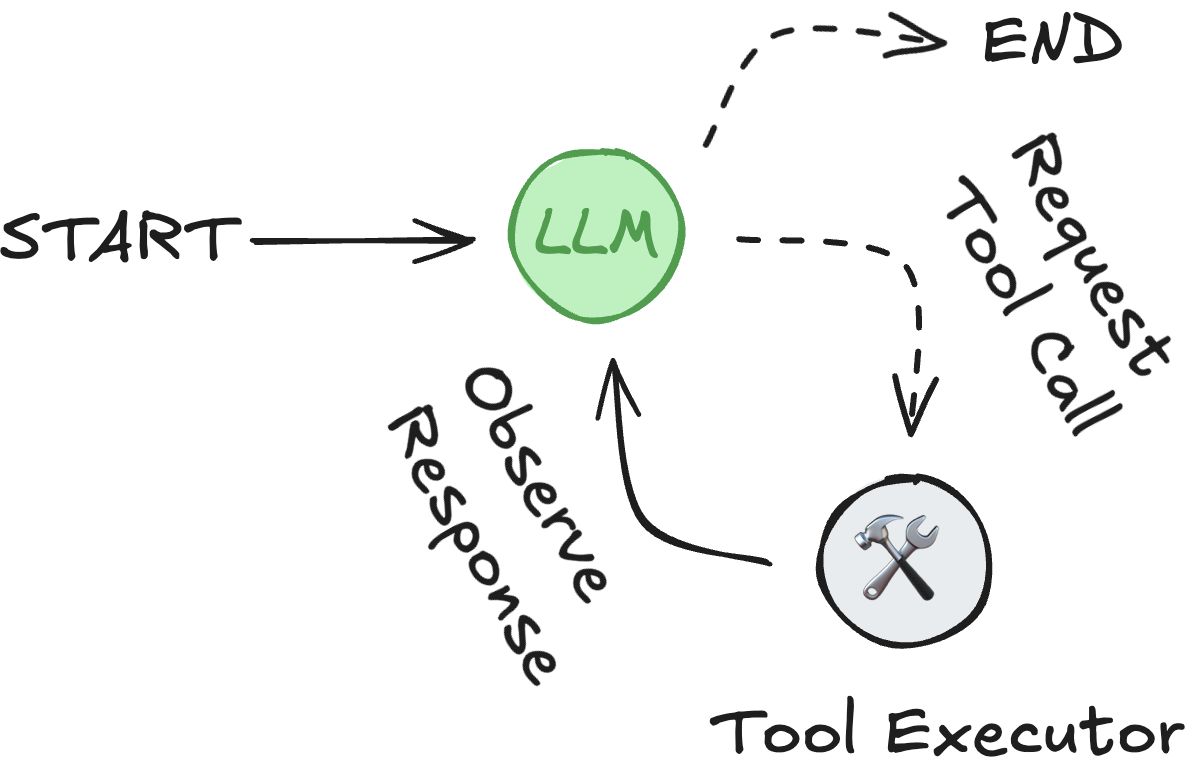

In [145]:
"""
To use LangGraph, we need to define three things:

The state of our application;
The nodes of our application (i.e., application steps);
The "control flow" of our application (e.g., the ordering of the steps).
"""



# Define state for application
# The state of our application controls what data is input to the application, transferred between steps, and output by the application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps : NODES

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}



In [146]:
# Control flow
## Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [147]:
response = graph.invoke({"question": "give me a summary "})
print(response["answer"])

I cannot provide a summary as no context was provided. Please provide the text or information you would like me to summarize.


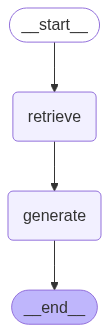

In [150]:
from IPython.display import Image, display
# Due to heavy traffic, https://mermaid.ink/ is struggle to operate normally.
display(Image(graph.get_graph().draw_mermaid_png()))